In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import optim
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# My Transformer model components

## Positional encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, max_len=5000):
        super().__init__()

        position = torch.arange(0, max_len).unsqueeze(1)
        i = torch.arange(0, emb_size, 2)
        div_term = torch.pow(10000.0, -2*i/emb_size)

        self.encoding = torch.zeros(max_len, emb_size)
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, emb):
        return emb + self.encoding[:, :emb.size(-2)].detach()

## Attention

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, emb_size, qkv_size, num_heads, use_bias=False):
        super().__init__()

        self.emb_size = emb_size
        self.qkv_size = qkv_size
        self.norm_coef = np.sqrt(qkv_size)
        self.num_heads = num_heads

        self.WQ = nn.Linear(emb_size, qkv_size * num_heads, bias=use_bias)
        self.WK = nn.Linear(emb_size, qkv_size * num_heads, bias=use_bias)
        self.WV = nn.Linear(emb_size, qkv_size * num_heads, bias=use_bias)
        self.W = nn.Linear(qkv_size * num_heads, emb_size)

    def forward(self, q_emb, k_emb, v_emb, mask=None):
        batch_size = q_emb.size(0)
        qkv_size, num_heads, emb_size = self.qkv_size, self.num_heads, self.emb_size
        q_len, k_len, v_len = q_emb.size(1), k_emb.size(1), v_emb.size(1)

        Q = self.WQ(q_emb).view(batch_size, num_heads, q_len,  qkv_size)
        K = self.WK(k_emb).view(batch_size, num_heads, k_len,  qkv_size)
        V = self.WV(v_emb).view(batch_size, num_heads, v_len,  qkv_size)

        energy = Q @ torch.transpose(K, -2, -1) / self.norm_coef
        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)

        weights = F.softmax(energy, dim=-1)

        attn_all_heads = weights @ V
        # [batch_size, num_heads, q_len, qkv_size]

        attn_all_heads = attn_all_heads.permute(0, 2, 1, 3).contiguous()
        # [batch_size, q_len, num_heads, qkv_size]

        attn_all_heads = attn_all_heads.view(batch_size, -1, num_heads * qkv_size)
        # [batch_size, q_len, num_heads * qkv_size]

        attention = self.W(attn_all_heads)

        return attention

## Feed forward

In [ ]:
class FeedForwardNet(nn.Module):
    def __init__(self, emb_size, linear_size):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, linear_size)
        self.nonlinear = nn.ReLU()
        self.fc2 = nn.Linear(linear_size, emb_size)

    def forward(self, emb):
        out = self.fc1(emb)
        out = self.nonlinear(out)
        out = self.fc2(out)
        return out

## Layer norm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = np.random.rand()
        self.beta = np.random.rand()

    def forward(self, emb):
        mean = emb.mean(dim=-1, keepdims=True)
        std = emb.std(dim=-1, keepdims=True)
        emb_normed = (emb - mean) / (std + self.eps)
        emb_normed *= self.gamma + self.beta
        return emb_normed

## Encoder

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, emb_size, qkv_size, num_heads, linear_size):
        super().__init__()
        self.self_attn = MultiheadAttention(emb_size, qkv_size, num_heads)
        self.layer_norm1 = LayerNorm()
        self.ff_net = FeedForwardNet(emb_size, linear_size)
        self.layer_norm2 = LayerNorm()

    def forward(self, source_seq):
        self_attn_out = self.self_attn(source_seq, source_seq, source_seq)
        source_seq = self.layer_norm1(source_seq + self_attn_out)
        ff_out = self.ff_net(source_seq)
        source_seq = self.layer_norm2(source_seq + ff_out)
        return source_seq

class Encoder(nn.Module):
    def __init__(self, num_blocks, **kwargs):
        super().__init__()
        self.enc_blocks = nn.ModuleList([EncoderBlock(**kwargs)])

    def forward(self, emb):
        for enc_block in self.enc_blocks:
            emb = enc_block(emb)
        return emb

## Decoder

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, emb_size, qkv_size, num_heads, linear_size, max_seq_len):
        super().__init__()
        self.mask = torch.ones(1, 1, max_seq_len, max_seq_len).triu(diagonal=1).bool()
        self.masked_self_attn = MultiheadAttention(emb_size, qkv_size, num_heads)
        self.layer_norm1 = LayerNorm()

        self.cross_attn = MultiheadAttention(emb_size, qkv_size, num_heads)
        self.layer_norm2 = LayerNorm()

        self.ff_net = FeedForwardNet(emb_size, linear_size)
        self.layer_norm3 = LayerNorm()

    def forward(self, target_seq, encoder_out):
        mask = self.mask[:, :, :target_seq.size(1), :target_seq.size(1)]
        self_attn_out = self.masked_self_attn(target_seq, target_seq, target_seq, mask)
        target_seq = self.layer_norm1(target_seq + self_attn_out)

        cross_attn_out = self.cross_attn(target_seq, encoder_out, encoder_out)
        target_seq = self.layer_norm2(target_seq + cross_attn_out)

        ff_out = self.ff_net(target_seq)
        target_seq = self.layer_norm3(target_seq + ff_out)
        return target_seq

class Decoder(nn.Module):
    def __init__(self, num_blocks, **kwargs):
        super().__init__()
        self.dec_blocks = nn.ModuleList([DecoderBlock(**kwargs)])

    def forward(self, target_emb, enc_emb):
        for dec_block in self.dec_blocks:
            emb = dec_block(target_emb, enc_emb)
        return emb

# My Transformer Language Model

## My Model

In [ ]:
class TransformerLM(nn.Module):
    def __init__(self,
                 num_blocks_enc, num_blocks_dec, num_heads_enc, num_heads_dec,

                 # COMMON ENC/DEC PARAMS
                 emb_size, qkv_size, linear_size,

                 # PARAMS FOR PRECOMPUTED EMBEDDINGS
                 emb_vocab, bos_id, eos_id,

                #  # PARAMS FOR NON-PRECOMPUTED EMBEDDINGS
                #  input_size, output_size,

                 use_pos_encoding=True, max_seq_len=10, teacher_forcing_ratio=0.5
                 ):
        super().__init__()

        # USE PRECOMPUTED EMBEDDINGS
        self.emb_vocab = emb_vocab
        self.bos_id = bos_id
        self.eos_id = eos_id

        # # USE NON-PRECOMPUTED EMBEDDINGS
        # self.embedding = nn.Linear(input_size, emb_size)

        self.max_seq_len = max_seq_len
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.use_pos_encoding = use_pos_encoding

        if use_pos_encoding:
            self.pos_encoding = PositionalEncoding(emb_size, max_seq_len)

        self.encoder = Encoder(
            num_blocks_enc,
            emb_size=emb_size,
            qkv_size=qkv_size,
            num_heads=num_heads_enc,
            linear_size=linear_size)

        self.decoder = Decoder(
            num_blocks_dec,
            emb_size=emb_size,
            qkv_size=qkv_size,
            num_heads=num_heads_dec,
            linear_size=linear_size,
            max_seq_len=max_seq_len)

        # USE PRECOMPUTED EMBEDDINGS
        self.final_linear = nn.Linear(emb_size, emb_vocab.size(0))

        # # USE NON-PRECOMPUTED EMBEDDINGS
        # self.final_linear = nn.Linear(emb_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_batch, target_batch):
        if self.use_pos_encoding:
            input_batch = self.pos_encoding(input_batch)
            target_batch = self.pos_encoding(target_batch)

        enc_out = self.encoder(input_batch)

        if self.training:
            dec_out = self.decoder(target_batch, enc_out)
            logits = self.final_linear(dec_out)
            probs = self.softmax(logits)
            next_emb_id_all = probs.argmax(dim=-1)
        else:
            batch_size = input_batch.size(0)
            emb_size = input_batch.size(-1)

            dec_in = self.emb_vocab[BOS_ID] \
                .unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)

            # START FROM <BOS> TOKEN
            next_emb_id = self.bos_id
            for i in range(self.max_seq_len):
                dec_out = self.decoder(dec_in, enc_out)
                logits = self.final_linear(dec_out)
                probs = self.softmax(logits)
                next_emb_id_all = probs.argmax(dim=-1)
                next_emb_id = next_emb_id_all[:, [-1]]
                next_emb = self.emb_vocab[next_emb_id.flatten()] \
                    .reshape(batch_size, 1, emb_size)
                dec_in = torch.cat([dec_in, next_emb], axis=-2)
                # TODO: for each sequence in batch
                #   fill sequence with <EOS> from first <EOS> till sequence end

        # TODO: grow a list of next_emb_ids instead of simply using decoder output??
        return next_emb_id_all



## Generate token data

In [ ]:
# generate vocabulary embedding space
# let first embedding be <BOS> token embedding filled with 0s
# let second embedding be <EOS> token embedding filled with 1s

VOCAB_SIZE = 128
EMB_SIZE = 4
BOS_ID = 0
EOS_ID = 1

emb_vocab = torch.rand(VOCAB_SIZE + 2, EMB_SIZE)
emb_vocab[BOS_ID] = torch.zeros(EMB_SIZE)
emb_vocab[EOS_ID] = torch.ones(EMB_SIZE)

In [ ]:
# generate dummy sequence of embeddings
# set first embedding to <BOS> token embedding
# set last embedding to <EOS> token embedding

MAX_SEQ_LEN = 10
SEQ_LEN = 5 # < MAX_LEN
BATCH_SIZE = 2

input_seq_list = []
for i in range(BATCH_SIZE):
    input_seq = torch.rand(SEQ_LEN, EMB_SIZE)
    input_seq[0] = emb_vocab[BOS_ID]
    input_seq[-1] = emb_vocab[EOS_ID]
    input_seq_list.append(input_seq)

input_batch = torch.stack(input_seq_list)
input_batch.shape # [B, S, H]

torch.Size([2, 5, 4])

In [ ]:
# generate dummy TARGET embeddings
# let first embedding be <BOS> token embedding filled with 0s
# let last embedding be <EOS> token embedding filled with 1s

# let target sequence have couple words more than input
MAX_SEQ_LEN = 8
SEQ_LEN = 5 + 2 # < MAX_LEN

target_batch_list = []
for i in range(BATCH_SIZE):
    target_seq = torch.rand(SEQ_LEN, EMB_SIZE)
    target_seq[0] = emb_vocab[BOS_ID]
    target_seq[-1] = emb_vocab[EOS_ID]
    target_batch_list.append(target_seq)

target_batch = torch.stack(target_batch_list)
target_batch.shape

torch.Size([2, 7, 4])

## Test model

In [ ]:
kwargs = dict(
    num_blocks_enc=10,
    num_blocks_dec=10,
    num_heads_enc=3,
    num_heads_dec=3,
    emb_size=EMB_SIZE,
    qkv_size=int(EMB_SIZE * 0.75),
    linear_size=EMB_SIZE * 4,
    emb_vocab=emb_vocab,
    bos_id=BOS_ID,
    eos_id=EOS_ID
)

my_model = TransformerLM(**kwargs)

In [ ]:
# during inference will generate sequence of MAX_SEQ_LEN
# TODO: generate till <EOS>

my_model.eval()

t_out = my_model(input_batch, target_batch)
t_out.shape

torch.Size([2, 10])

In [ ]:
# during training will generate sequence of max sequence length in target_batch

my_model.train()

t_out = my_model(input_batch, target_batch)
t_out.shape

torch.Size([2, 7])

# Time Series Transformer

## My Model

In [ ]:
class MyTransformerRegression(nn.Module):
    def __init__(self,
                 num_blocks_enc, num_blocks_dec, num_heads_enc, num_heads_dec,

                 # COMMON ENC/DEC PARAMS
                 emb_size, qkv_size, linear_size,

                 # PARAMS FOR NON-PRECOMPUTED EMBEDDINGS
                 input_size, output_size,

                 max_seq_len, use_pos_encoding=True, teacher_forcing_ratio=0.5
                 ):
        super().__init__()

        self.emb_size = emb_size
        self.max_seq_len = max_seq_len
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.use_pos_encoding = use_pos_encoding

        # USE NON-PRECOMPUTED EMBEDDINGS
        self.embedding = nn.Linear(input_size, emb_size)

        if use_pos_encoding:
            self.pos_encoding = PositionalEncoding(emb_size, max_seq_len)

        self.encoder = Encoder(
            num_blocks_enc,
            emb_size=emb_size,
            qkv_size=qkv_size,
            num_heads=num_heads_enc,
            linear_size=linear_size)

        self.decoder = Decoder(
            num_blocks_dec,
            emb_size=emb_size,
            qkv_size=qkv_size,
            num_heads=num_heads_dec,
            linear_size=linear_size,
            max_seq_len=max_seq_len)

        # USE NON-PRECOMPUTED EMBEDDINGS
        self.final_linear = nn.Linear(emb_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_seq, target_seq):
        input_seq = self.embedding(input_seq)
        target_seq = self.embedding(target_seq)
        if self.use_pos_encoding:
            input_seq = self.pos_encoding(input_seq)
            target_seq = self.pos_encoding(target_seq)

        enc_out = self.encoder(input_seq)

        if self.training:
            dec_out = self.decoder(target_seq, enc_out)
            pred_seq = self.final_linear(dec_out)
        else:
            batch_size = input_seq.size(0)
            emb_size = self.emb_size

            # START FROM ZEROS
            dec_in = target_seq[:, [0], :]

            for i in range(target_seq.size(1)):
                # breakpoint()
                dec_out = self.decoder(dec_in, enc_out)
                pred_seq = self.final_linear(dec_out)
                dec_in = torch.cat([dec_in, dec_out[:, [-1], :]], axis=-2)

        return pred_seq

## Reference model

In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, \
    TransformerDecoderLayer, TransformerDecoder

class ReferencePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(ReferencePositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).to(DEVICE)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)].detach()

class ReferenceTransformerRegression(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, hidden_dim, num_layers):
        super(ReferenceTransformerRegression, self).__init__()
        self.pos_enc = ReferencePositionalEncoding(hidden_dim,1000)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = TransformerEncoderLayer(hidden_dim, nhead, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers)
        decoder_layer = TransformerDecoderLayer(hidden_dim, nhead, batch_first=True)
        self.decoder = TransformerDecoder(decoder_layer, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, y):
        x = self.embedding(x)
        y = self.embedding(y)

        x = self.pos_enc(x) # [batch, seq, emb]
        y = self.pos_enc(y)

        enc_out = self.encoder(x)  # Применяем трансформер
        if self.training:
            mask = torch.ones(1, y.size(1), y.size(1)).triu(diagonal=1).bool()
            dec_out = self.decoder(y, enc_out, tgt_mask=mask, tgt_is_causal=True)
        else:
            dec_in = y[:, [0], :]
            outputs = torch.empty(0)
            for i in range(y.size(1)):
                dec_out = self.decoder(dec_in, enc_out)
                dec_in = torch.cat([dec_in, dec_out[:, [-1], :]], dim=-2)

        output = self.fc(dec_out)  # Полносвязный слой для предсказания
        return output

In [ ]:
X, Y = gen_data(1, CHANNELS)
reference_model(X, Y).shape

torch.Size([1, 1, 1])

## Frankenstein model

In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer, \
    TransformerDecoderLayer, TransformerDecoder

class FrankensteinTransformerRegression(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, hidden_dim, num_layers):
        super(FrankensteinTransformerRegression, self).__init__()
        self.pos_enc = ReferencePositionalEncoding(hidden_dim,1000)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = TransformerEncoderLayer(hidden_dim, nhead, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers)
        decoder_layer = TransformerDecoderLayer(hidden_dim, nhead, batch_first=True)
        self.decoder = TransformerDecoder(decoder_layer, num_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, y):
        x = self.embedding(x)
        y = self.embedding(y)

        x = self.pos_enc(x) # [batch, seq, emb]
        y = self.pos_enc(y)

        enc_out = self.encoder(x)  # Применяем трансформер
        if self.training:
            mask = torch.ones(1, y.size(1), y.size(1)).triu(diagonal=1).bool()
            dec_out = self.decoder(y, enc_out, tgt_mask=mask, tgt_is_causal=True)
        else:
            dec_in = y[:, [0], :]
            for i in range(y.size(1)):
                dec_out = self.decoder(dec_in, enc_out)
                dec_in = torch.cat([dec_in, dec_out[:, [-1], :]], dim=-2)


        # output = output[:,0,:] # take first token in sequence??
        output = self.fc(dec_out)  # Полносвязный слой для предсказания
        return output

## Generate data

In [ ]:
def gen_data(batch = 16, channels = 1, batch_first=True):
    t = np.arange(0,torch.randint(5,15,(1,)),step=0.1)

    X = torch.zeros(t.size-30, batch, channels)
    Y = torch.zeros(30, batch, channels)
    for i in range(batch):
        for k in range(channels):
            a = torch.rand(1)*3 + 0.1
            b = torch.rand(1)*4 + 0.2

            y = a*np.sin(b*t)
            X[:,i,k] =  y[:-30]
            Y[:,i,k] = y[-30:]

    if batch_first:
        X = X.permute(1, 0, -1)
        Y = Y.permute(1, 0, -1)

    return X,Y

In [ ]:
def plot_timeseries(x, y, y_pred=None, title=None, batch_first=True):
    if batch_first:
        x, y = x[0, :, :], y[0, :, :]
        if y_pred is not None:
            y_pred = y_pred[0, :, :]
    else:
        x, y = x[:, 0, :], y[:, 0, :]
        if y_pred is not None:
            y_pred = y_pred[:, 0, :]

    x = x.detach().cpu()
    y = y.detach().cpu()

    tgt_len = y.size(0)

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(x)), x.detach().squeeze() , label='X')
    plt.plot(np.arange(len(x), len(x)+tgt_len), y, label='Y', linestyle='dashed')

    if y_pred is not None:
        y_pred = y_pred.detach().cpu()
        plt.plot(np.arange(len(x), len(x)+tgt_len), y_pred, label='Y_pred', linestyle='dashdot')

    if title is not None:
        plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## Train/eval

In [ ]:
# common params
CHANNELS = 1
EMB_SIZE = 32
NUM_HEADS = 2
NUM_LAYERS = 2

In [ ]:
#@title Train/eval func
def train_model(model, batch_size=4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    s = []
    # Обучение модели
    num_epochs = 4000
    model = model.to(DEVICE)
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        x,y = gen_data(batch=batch_size, channels = CHANNELS)
        output = model(x.to(DEVICE), y.to(DEVICE))

        loss = criterion(output, y.to(DEVICE))  # Используем только первый измерение для задачи регрессии
        loss.backward()
        optimizer.step()
        l = loss.detach().to('cpu')
        s.append(l)
        if (epoch + 1) % 100 == 0:
            L = np.mean(s)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {L:.4f}')
            s = []

def eval_model(model):
    criterion = nn.MSELoss()
    model_name = model.__class__.__name__
    X, Y = gen_data(BATCH_SIZE * 2, CHANNELS)
    title = "MODEL: {model_name} \n{loss_type} LOSS: {loss}"

    model.train()
    Y_pred_train = model(X.to(DEVICE), Y.to(DEVICE))
    train_loss = criterion(Y_pred_train, Y.to(DEVICE)).detach().item()
    train_title = title.format(model_name=model_name, loss_type='TRAIN', loss=round(train_loss, 2))
    plot_timeseries(X, Y, Y_pred_train, train_title)

    model.eval()
    Y_pred_test = model(X.to(DEVICE), Y.to(DEVICE))
    test_loss = criterion(Y_pred_test, Y.to(DEVICE)).detach().item()
    test_title = title.format(model_name=model_name, loss_type='TEST', loss=round(test_loss, 2))
    plot_timeseries(X, Y, Y_pred_test, test_title)

### Train Reference model

In [ ]:
reference_model = ReferenceTransformerRegression(
    input_dim=CHANNELS,
    output_dim=CHANNELS,
    nhead=NUM_HEADS,
    hidden_dim=EMB_SIZE,
    num_layers=NUM_LAYERS)

In [ ]:
train_model(reference_model)

Epoch [100/4000], Loss: 0.1409
Epoch [200/4000], Loss: 0.0243
Epoch [300/4000], Loss: 0.0187
Epoch [400/4000], Loss: 0.0206
Epoch [500/4000], Loss: 0.0123
Epoch [600/4000], Loss: 0.0108
Epoch [700/4000], Loss: 0.0092
Epoch [800/4000], Loss: 0.0083
Epoch [900/4000], Loss: 0.0126
Epoch [1000/4000], Loss: 0.0056
Epoch [1100/4000], Loss: 0.0056
Epoch [1200/4000], Loss: 0.0070
Epoch [1300/4000], Loss: 0.0045
Epoch [1400/4000], Loss: 0.0052
Epoch [1500/4000], Loss: 0.0077
Epoch [1600/4000], Loss: 0.0092
Epoch [1700/4000], Loss: 0.0137
Epoch [1800/4000], Loss: 0.0173
Epoch [1900/4000], Loss: 0.0047


KeyboardInterrupt: 

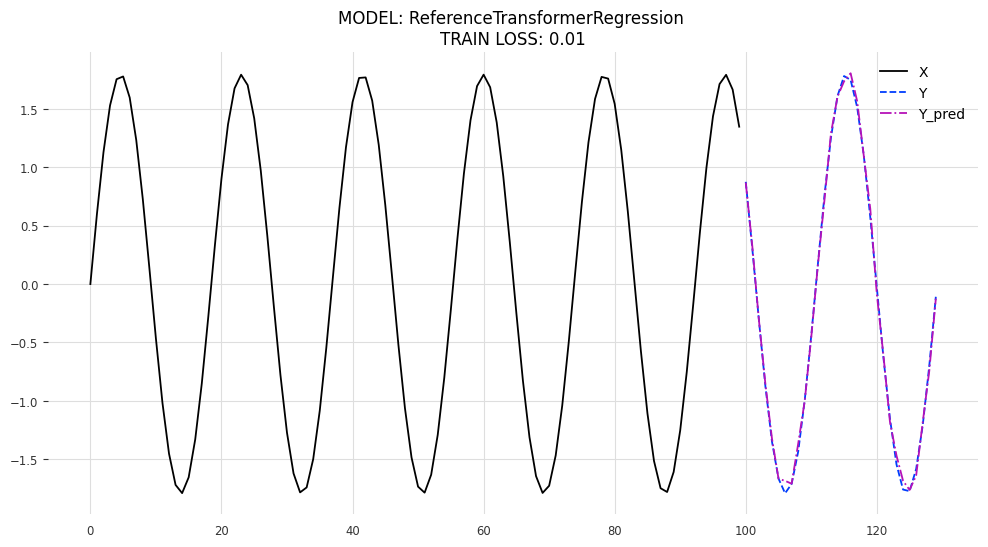

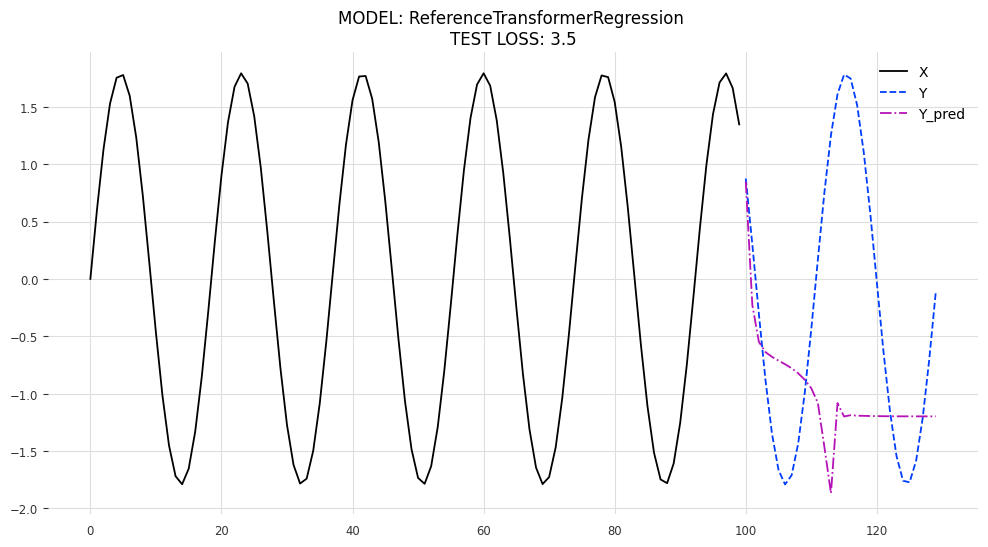

In [ ]:
# collect predictions step by step
eval_model(reference_model)

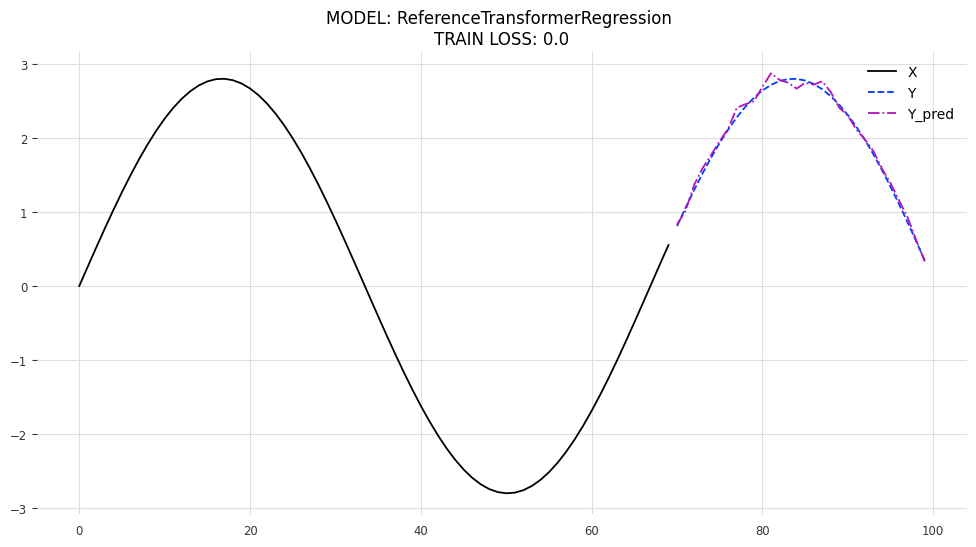

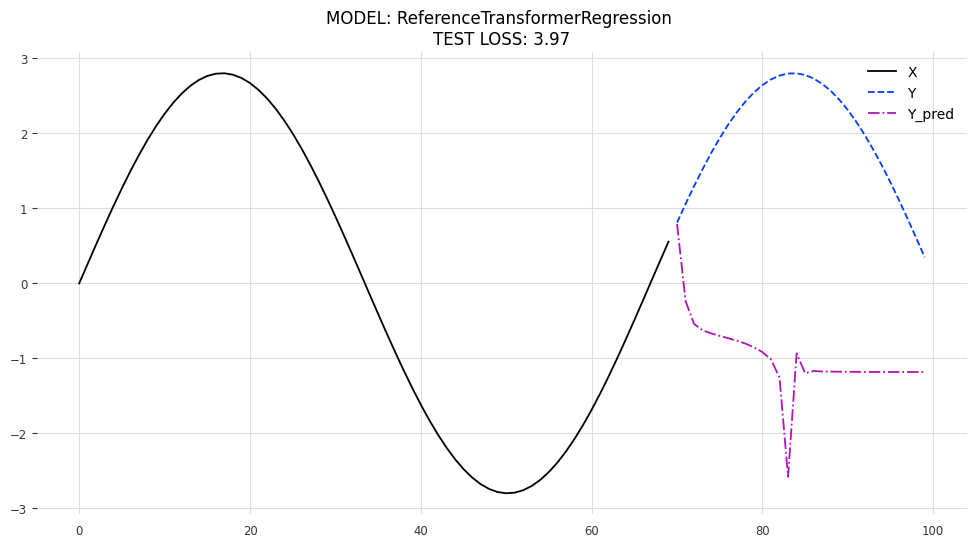

In [ ]:
# concat last (-1) token
eval_model(reference_model)

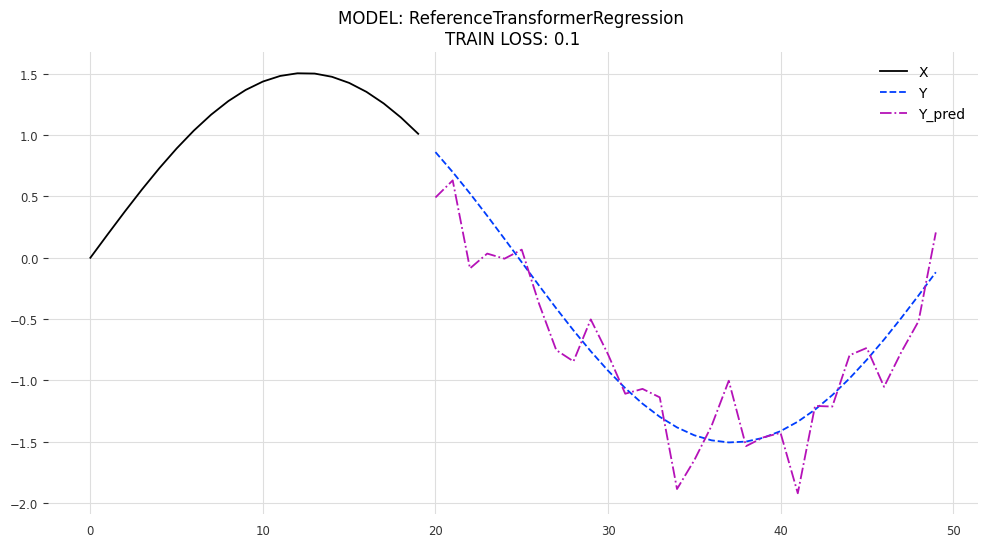

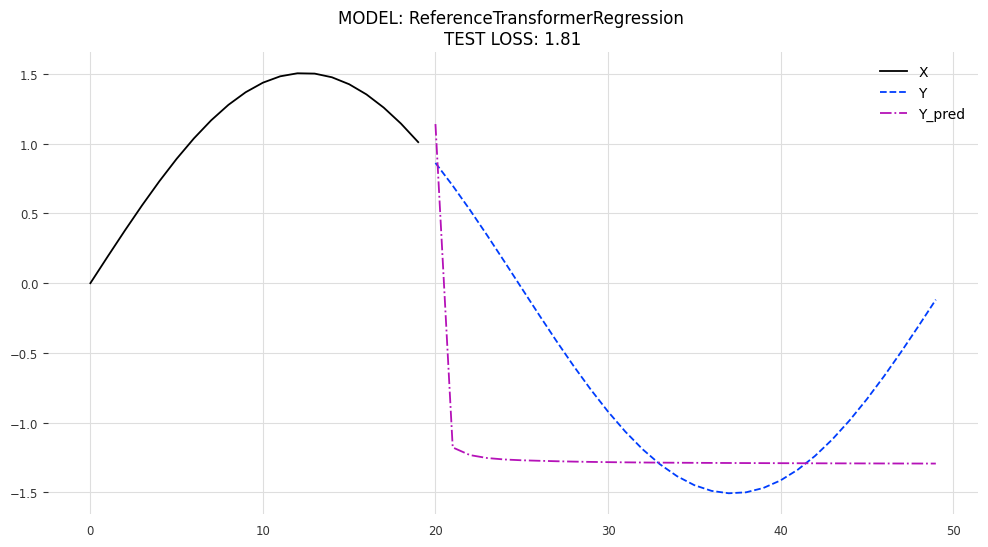

In [ ]:
# concat first (0) token
eval_model(reference_model)

In [ ]:
train_model(my_model)

Epoch [100/4000], Loss: 0.1697
Epoch [200/4000], Loss: 0.0061
Epoch [300/4000], Loss: 0.0024
Epoch [400/4000], Loss: 0.0014
Epoch [500/4000], Loss: 0.0013
Epoch [600/4000], Loss: 0.0009
Epoch [700/4000], Loss: 0.0008
Epoch [800/4000], Loss: 0.0007


KeyboardInterrupt: 

### Train My model

In [ ]:
kwargs = dict(
    input_size=CHANNELS,
    output_size=CHANNELS,

    num_blocks_enc=NUM_LAYERS,
    num_blocks_dec=NUM_LAYERS,

    num_heads_enc=NUM_HEADS,
    num_heads_dec=NUM_HEADS,

    emb_size=EMB_SIZE,

    qkv_size=int(EMB_SIZE * 0.75),
    linear_size=EMB_SIZE * 4,
    max_seq_len=1024
)

my_model = MyTransformerRegression(**kwargs)

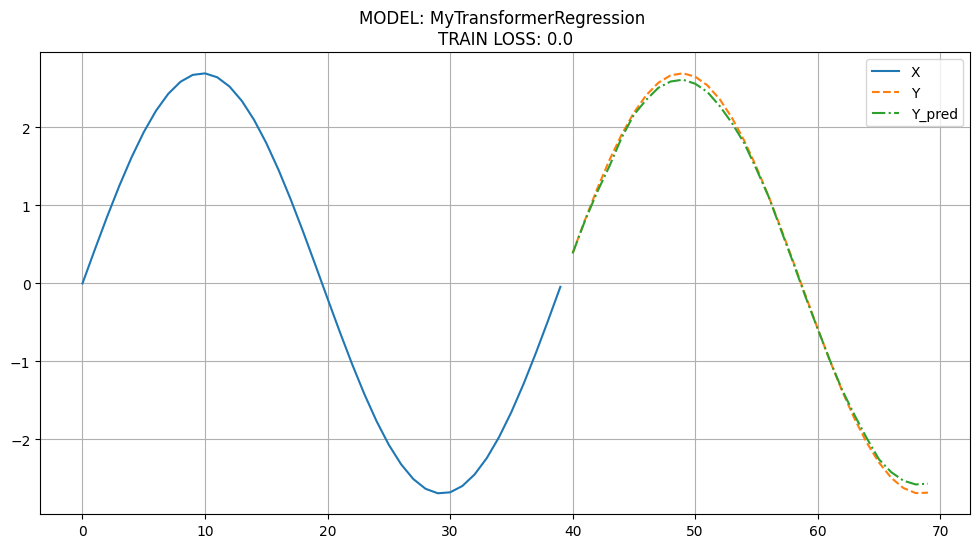

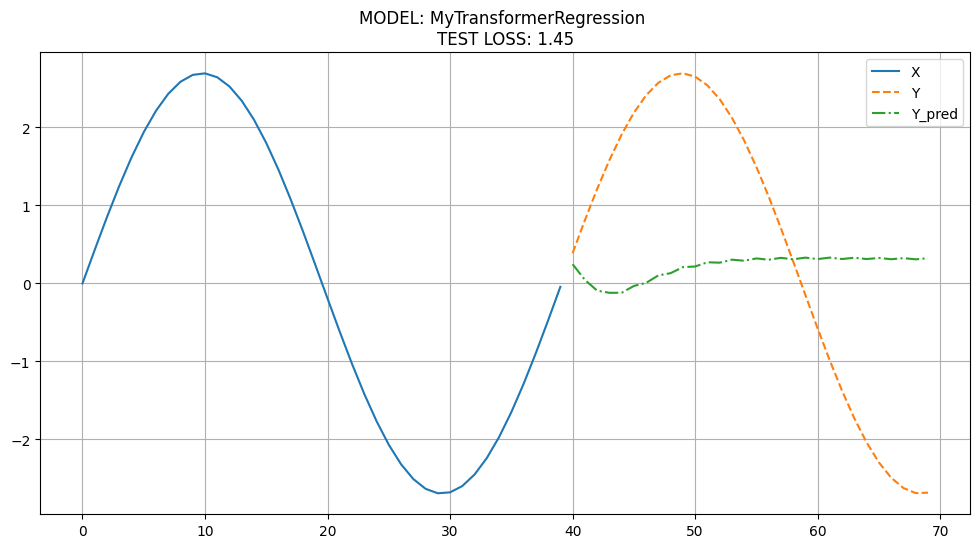

In [ ]:
eval_model(my_model)

### Train Frank Model

In [ ]:
frank_model = FrankensteinTransformerRegression(
    input_dim=CHANNELS,
    output_dim=CHANNELS,
    nhead=NUM_HEADS,
    hidden_dim=EMB_SIZE,
    num_layers=NUM_LAYERS)

In [ ]:
train_model(frank_model)

Epoch [100/4000], Loss: 0.1279
Epoch [200/4000], Loss: 0.0182
Epoch [300/4000], Loss: 0.0131
Epoch [400/4000], Loss: 0.0107
Epoch [500/4000], Loss: 0.0105
Epoch [600/4000], Loss: 0.0085
Epoch [700/4000], Loss: 0.0083


KeyboardInterrupt: 

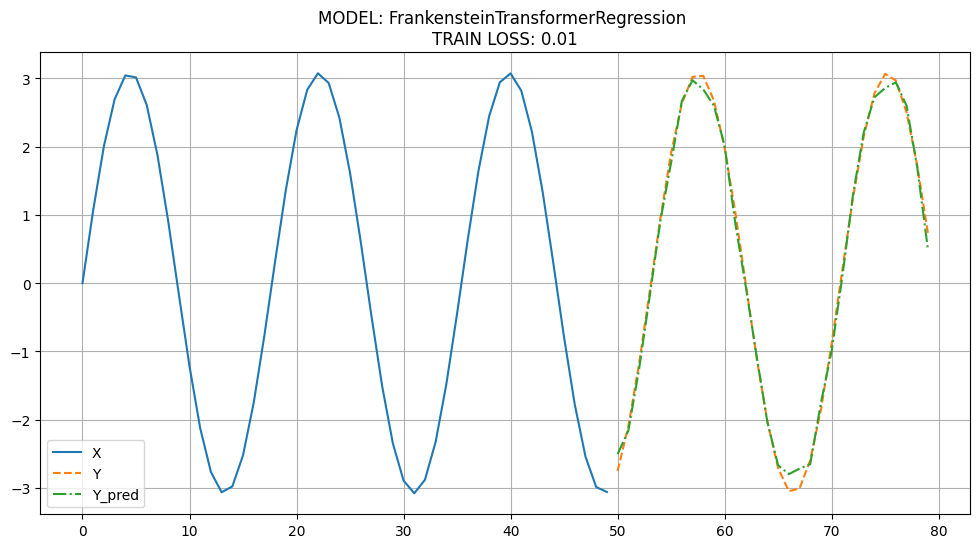

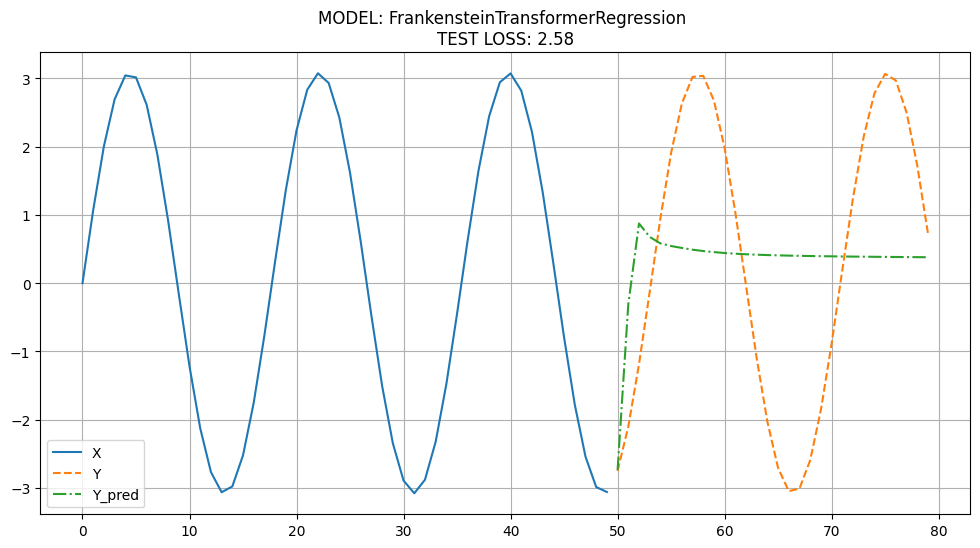

In [ ]:
eval_model(frank_model)

# Darts model

In [ ]:
!pip install -q darts

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")

## Example: Air dataset

In [ ]:
# Read data:
series = AirPassengersDataset().load().astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)

"the 'air passengers' dataset has {} data points".format(len(series))

"the 'air passengers' dataset has 144 data points"

In [ ]:
air_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=100,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)
air_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TransformerModel(output_chunk_shift=0, d_model=16, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=12, output_chunk_length=1, batch_size=32, n_epochs=200, model_name=air_transformer, nr_epochs_val_period=10, random_state=42, save_checkpoints=True, force_reset=True)

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_darts_model(model, n, series_obj, val_series_obj, multiple=False):
    if not multiple:
        pred_series = model.predict(n=n)

        plt.figure(figsize=(8, 5))
        series_obj.plot(label="actual")
        pred_series.plot(label="forecast")
        plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
        plt.legend()
    else:
        for series_idx in range(len(series_obj)):
            plt.figure(figsize=(8, 5))
            series = series_obj[series_idx]
            val_series = val_series_obj[series_idx]
            pred_series = model.predict(n, series)
            mape_str = "MAPE: {:.2f}%".format(mape(pred_series, val_series))
            # series.plot(label=f"actual {series_idx}" + mape_str)
            series.plot(label=f"actual {series_idx}")
            pred_series.plot(label=f"forecast {series_idx}")
            plt.title(mape_str)
            plt.legend()

Predicting: |          | 0/? [00:00<?, ?it/s]

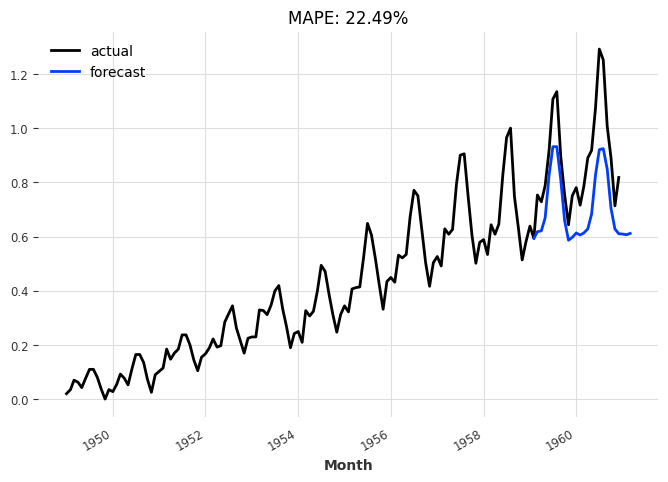

In [ ]:
eval_darts_model(air_model, 26, series_scaled, val_scaled)

 ## My data

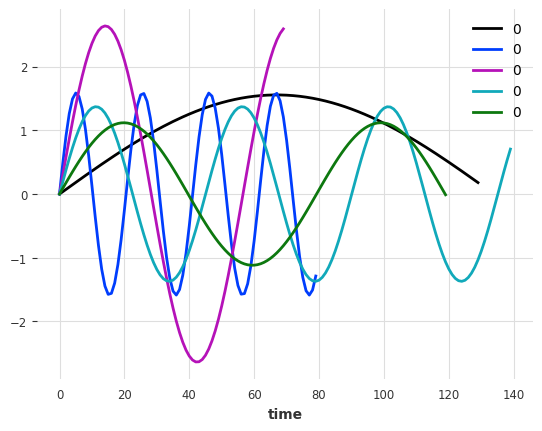

In [ ]:
import pandas as pd
import darts

def gen_darts_data(samples=5):
    x_ts_list = []
    y_ts_list = []
    xy_ts_list = []
    for i in range(samples):
        X, Y = gen_data(BATCH_SIZE)
        X_times = np.arange(X.size(1))
        Y_times = np.arange(X.size(1), X.size(1)+Y.size(1))

        x_ts = TimeSeries.from_times_and_values(pd.Index(X_times), X[0].numpy())
        y_ts = TimeSeries.from_times_and_values(pd.Index(Y_times), Y[0].numpy())
        xy_ts = darts.timeseries.concatenate([x_ts, y_ts])

        x_ts_list.append(x_ts)
        y_ts_list.append(y_ts)
        xy_ts_list.append(xy_ts)

    return x_ts_list, y_ts_list, xy_ts_list

x_ts_list, y_ts_list, xy_ts_list = gen_darts_data()
for xy_ts in xy_ts_list:
    xy_ts.plot()

### Basic model

In [ ]:
darts_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=100,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)
darts_model.fit(series=x_ts_list, val_series=y_ts_list, verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TransformerModel(output_chunk_shift=0, d_model=16, nhead=8, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=12, output_chunk_length=1, batch_size=32, n_epochs=100, model_name=air_transformer, nr_epochs_val_period=10, random_state=42, save_checkpoints=True, force_reset=True)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

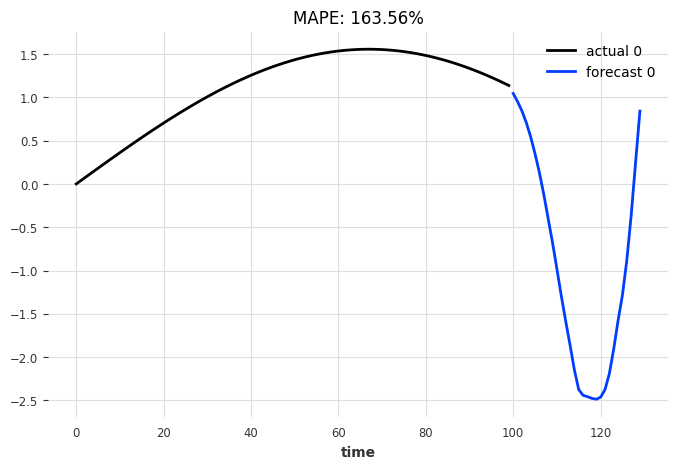

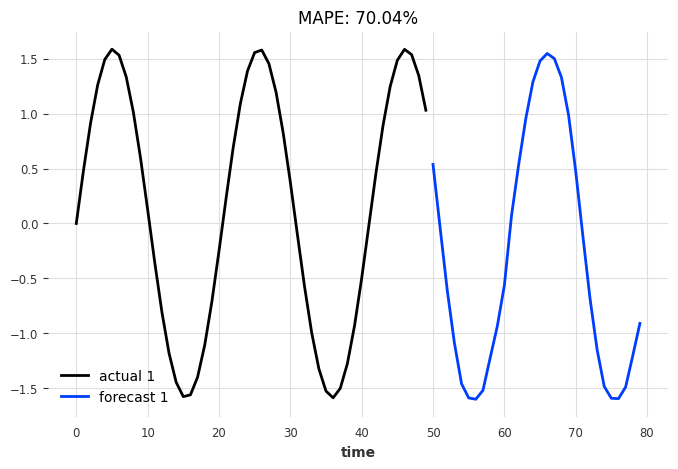

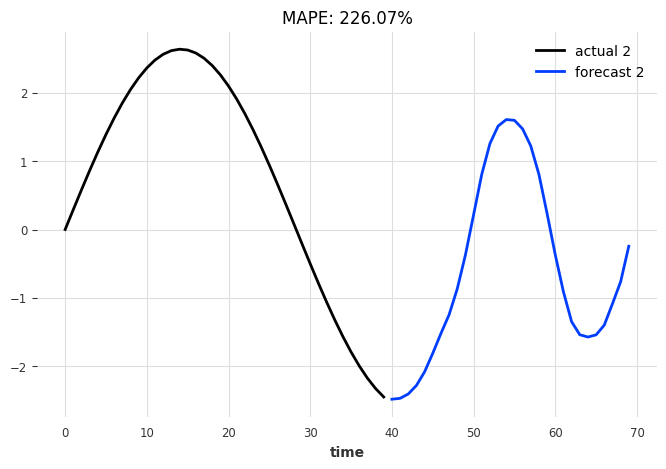

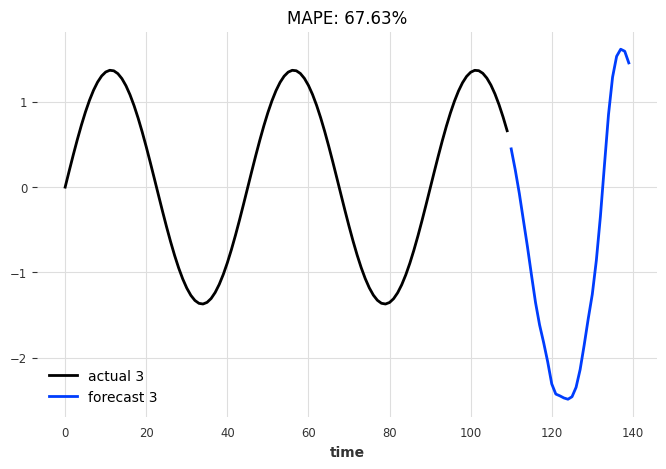

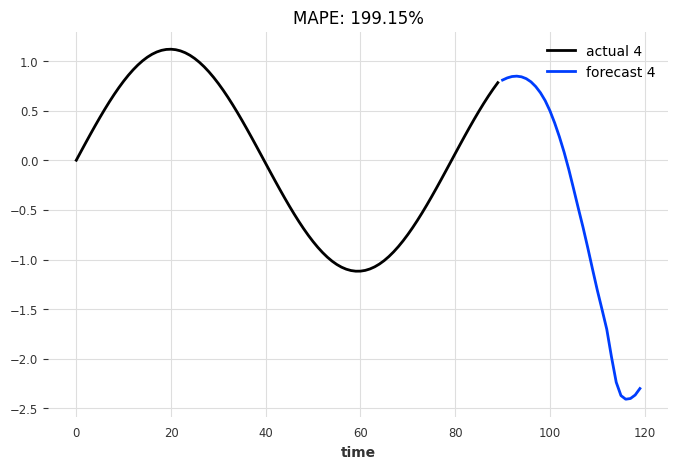

In [ ]:
eval_darts_model(darts_model, 30, x_ts_list, y_ts_list, multiple=True)

### Custom enc/dec layers

In [ ]:
nhead = 8
num_layers = 2
d_model = 16

encoder_layer = TransformerEncoderLayer(d_model, nhead, batch_first=True)
decoder_layer = TransformerDecoderLayer(d_model, nhead, batch_first=True)

custom_encoder = TransformerEncoder(encoder_layer, num_layers)
custom_decoder = TransformerDecoder(decoder_layer=decoder_layer, num_layers=num_layers)

darts_model = TransformerModel(
    custom_encoder = custom_encoder,
    custom_decoder = custom_decoder,
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=100,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

darts_model.fit(series=x_ts, val_series=y_ts, verbose=True)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: shape '[18, 8, 2]' is invalid for input of size 3456

In [ ]:
eval_darts_model(darts_model, 30, xy_ts, y_ts)

NameError: name 'eval_darts_model' is not defined

# Random github model

In [ ]:
!pip install -q pytorch-lightning

In [ ]:
# https://github.com/CVxTz/time_series_forecasting

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import Linear


def loss_fn(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()

def loss_fn(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()


def gen_trg_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1

    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )

    return mask


class TimeSeriesForcasting(pl.LightningModule):
    def __init__(
        self,
        n_encoder_inputs,
        n_decoder_inputs,
        output_size,
        d_model=512,
        dropout=0.1,
        lr=1e-4,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.lr = lr
        self.dropout = dropout

        self.input_pos_embedding = torch.nn.Embedding(1024, embedding_dim=d_model)
        self.target_pos_embedding = torch.nn.Embedding(1024, embedding_dim=d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * d_model,
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=4 * d_model,
        )

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=8)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=8)

        self.input_projection = Linear(n_encoder_inputs, d_model)
        self.output_projection = Linear(n_decoder_inputs, d_model)

        self.linear = Linear(d_model, output_size)

        self.do = nn.Dropout(p=self.dropout)

    def encode_src(self, src):
        src_start = self.input_projection(src).permute(1, 0, 2)

        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )

        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)

        src = src_start + pos_encoder

        src = self.encoder(src) + src_start

        return src

    def decode_trg(self, trg, memory):

        trg_start = self.output_projection(trg).permute(1, 0, 2)

        out_sequence_len, batch_size = trg_start.size(0), trg_start.size(1)

        pos_decoder = (
            torch.arange(0, out_sequence_len, device=trg.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)

        trg = pos_decoder + trg_start

        trg_mask = gen_trg_mask(out_sequence_len, trg.device)

        out = self.decoder(tgt=trg, memory=memory, tgt_mask=trg_mask) + trg_start

        out = out.permute(1, 0, 2)

        out = self.linear(out)

        return out

    def forward(self, x):
        src, trg = x

        src = self.encode_src(src)

        out = self.decode_trg(trg=trg, memory=src)

        return out

    def training_step(self, batch, batch_idx):
        src, trg_in, trg_out = batch

        y_hat = self((src, trg_in))

        y_hat = y_hat.view(-1)
        y = trg_out.contiguous().view(-1)

        loss = loss_fn(y_hat, y)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        src, trg_in, trg_out = batch

        y_hat = self((src, trg_in))

        y_hat = y_hat.view(-1)
        y = trg_out.view(-1)

        loss = loss_fn(y_hat, y)

        self.log("valid_loss", loss)

        return loss

    def test_step(self, batch, batch_idx):
        src, trg_in, trg_out = batch

        y_hat = self((src, trg_in))

        y_hat = y_hat.view(-1)
        y = trg_out.view(-1)

        loss = loss_fn(y_hat, y)

        self.log("test_loss", loss)

        return loss

    def predict_step(self, batch, batch_idx):
        src, trg_in, trg_out = batch

        y_hat = self((src, trg_in))

        y_hat = y_hat.view(-1)
        y = trg_out.view(-1)

        loss = loss_fn(y_hat, y)

        self.log("test_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10, factor=0.1
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "valid_loss",
        }


In [ ]:
x, y = gen_data(16, 2)
x.shape, y.shape

(torch.Size([16, 40, 2]), torch.Size([16, 30, 2]))

In [ ]:
n_classes = 100

source = torch.rand(size=(32, 16, 9))

target_in = torch.rand(size=(32, 8, 9))
target_out = torch.rand(size=(32, 8, 9))

source

ts = TimeSeriesForcasting(n_encoder_inputs=9, n_decoder_inputs=9, output_size=9)

# pred = ts((source, target_in))

# print(pred.size())

ts.training_step((source, target_in, target_out), batch_idx=1)

tensor(1.6023, grad_fn=<MeanBackward0>)

In [ ]:
#@title Train/eval func
def train_model(model, batch_size=4, pl_model=False):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    s = []
    # Обучение модели
    num_epochs = 4000
    model = model.to(DEVICE)
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        x,y = gen_data(batch=batch_size, channels = CHANNELS)
        if not pl_model:
            output = model(x.to(DEVICE), y.to(DEVICE))
            loss = criterion(output, y.to(DEVICE))  # Используем только первый измерение для задачи регрессии
            loss.backward()
            optimizer.step()
        else:
            loss = model.training_step((x, y, y), batch_idx=epoch)

        l = loss.detach().to('cpu')
        s.append(l)
        if (epoch + 1) % 100 == 0:
            L = np.mean(s)
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {L:.4f}')
            s = []

def eval_model(model):
    criterion = nn.MSELoss()
    model_name = model.__class__.__name__
    X, Y = gen_data(BATCH_SIZE * 2, CHANNELS)
    title = "MODEL: {model_name} \n{loss_type} LOSS: {loss}"

    model.train()
    Y_pred_train = model(X.to(DEVICE), Y.to(DEVICE))
    train_loss = criterion(Y_pred_train, Y.to(DEVICE)).detach().item()
    train_title = title.format(model_name=model_name, loss_type='TRAIN', loss=round(train_loss, 2))
    plot_timeseries(X, Y, Y_pred_train, train_title)

    model.eval()
    Y_pred_test = model(X.to(DEVICE), Y.to(DEVICE))
    test_loss = criterion(Y_pred_test, Y.to(DEVICE)).detach().item()
    test_title = title.format(model_name=model_name, loss_type='TEST', loss=round(test_loss, 2))
    plot_timeseries(X, Y, Y_pred_test, test_title)

In [ ]:
ts = TimeSeriesForcasting(
    n_encoder_inputs=CHANNELS,
    n_decoder_inputs=CHANNELS,
    output_size=CHANNELS)
train_model(ts, pl_model=True)

Epoch [100/4000], Loss: 1.3231
Epoch [200/4000], Loss: 1.3472
Epoch [300/4000], Loss: 1.3488
Epoch [400/4000], Loss: 1.3661


KeyboardInterrupt: 